# Categorical Data
This section introduces the pandas Categorical type. I will show how you can achieve
better performance and memory use in some pandas operations by using it. I
also introduce some tools for using categorical data in statistics and machine learning
applications.

## Background and Motivation
Frequently, a column in a table may contain repeated instances of a smaller set of distinct
values. We have already seen functions like `unique` and `value_counts`, which
enable us to extract the distinct values from an array and compute their frequencies,
respectively:

In [1]:
import numpy as np
import pandas as pd

In [2]:
values = pd.Series(['apple', 'orange', 'apple','apple'] * 2)
values

0     apple
1    orange
2     apple
3     apple
4     apple
5    orange
6     apple
7     apple
dtype: object

In [3]:
pd.unique(values)

array(['apple', 'orange'], dtype=object)

In [4]:
pd.value_counts(values)

apple     6
orange    2
dtype: int64

Many data systems (for data warehousing, statistical computing, or other uses) have
developed specialized approaches for representing data with repeated values for more
efficient storage and computation. In data warehousing, a best practice is to use socalled
dimension tables containing the distinct values and storing the primary observations
as integer keys referencing the dimension table:

In [5]:
values = pd.Series([0, 1, 0, 0] * 2)
values

0    0
1    1
2    0
3    0
4    0
5    1
6    0
7    0
dtype: int64

In [6]:
dim = pd.Series(['apple', 'orange'])
dim

0     apple
1    orange
dtype: object

We can use the take method to restore the original Series of strings:

In [7]:
dim.take(values)

0     apple
1    orange
0     apple
0     apple
0     apple
1    orange
0     apple
0     apple
dtype: object

This representation as integers is called the categorical or dictionary-encoded representation.
The array of distinct values can be called the categories, dictionary, or levels
of the data. In this book we will use the terms categorical and categories. The integer
values that reference the categories are called the category codes or simply codes.  
The categorical representation can yield significant performance improvements when
you are doing analytics. You can also perform transformations on the categories while
leaving the codes unmodified. Some example transformations that can be made at
relatively low cost are:
+ Renaming categories
+ Appending a new category without changing the order or position of the existing
categories

## Categorical Type in pandas

pandas has a special Categorical type for holding data that uses the integer-based
categorical representation or encoding. Let’s consider the example Series from before:

In [8]:
fruits = ['apple', 'orange', 'apple', 'apple'] * 2
N = len(fruits)
df = pd.DataFrame({'fruit': fruits, 'basket_id': np.arange(N),
                   'count': np.random.randint(3, 15, size=N),
                   'weight': np.random.uniform(0, 4, size=N)},
                  columns=['basket_id', 'fruit', 'count', 'weight'])
df

,basket_id,fruit,count,weight
0,0,apple,6,2.915715
1,1,orange,11,3.818335
2,2,apple,9,0.107359
3,3,apple,8,1.500283
4,4,apple,8,2.322532
5,5,orange,9,2.508901
6,6,apple,8,2.482937
7,7,apple,8,0.468900


Here, df['fruit'] is an array of Python string objects. We can convert it to categorical
by calling:

In [9]:
fruit_cat = df['fruit'].astype('category')
fruit_cat

0     apple
1    orange
2     apple
3     apple
4     apple
5    orange
6     apple
7     apple
Name: fruit, dtype: category
Categories (2, object): ['apple', 'orange']

The values for fruit_cat are not a NumPy array, but an instance of pandas.Categorical:

In [10]:
c = fruit_cat.values
type(c)

pandas.core.arrays.categorical.Categorical

The Categorical object has categories and codes attributes:

In [11]:
c.categories

Index(['apple', 'orange'], dtype='object')

In [12]:
c.codes

array([0, 1, 0, 0, 0, 1, 0, 0], dtype=int8)

You can convert a DataFrame column to categorical by assigning the converted result:

In [13]:
df['fruit'] = df['fruit'].astype('category')
df.fruit

0     apple
1    orange
2     apple
3     apple
4     apple
5    orange
6     apple
7     apple
Name: fruit, dtype: category
Categories (2, object): ['apple', 'orange']

You can also create pandas.Categorical directly from other types of Python
sequences:

In [14]:
my_categories = pd.Categorical(['foo', 'bar', 'baz', 'foo', 'bar'])
my_categories

['foo', 'bar', 'baz', 'foo', 'bar']
Categories (3, object): ['bar', 'baz', 'foo']

If you have obtained categorical encoded data from another source, you can use the
alternative from_codes constructor:

In [15]:
categories = ['foo', 'bar', 'baz']
codes = [0, 1, 2, 0, 0, 1]
my_cats_2 = pd.Categorical.from_codes(codes, categories)
my_cats_2

['foo', 'bar', 'baz', 'foo', 'foo', 'bar']
Categories (3, object): ['foo', 'bar', 'baz']

Unless explicitly specified, categorical conversions assume no specific ordering of the
categories. So the categories array may be in a different order depending on the
ordering of the input data. When using from_codes or any of the other constructors,
you can indicate that the categories have a meaningful ordering:

In [16]:
ordered_cat = pd.Categorical.from_codes(codes, categories, ordered=True)
ordered_cat

['foo', 'bar', 'baz', 'foo', 'foo', 'bar']
Categories (3, object): ['foo' < 'bar' < 'baz']

The output [foo < bar < baz] indicates that 'foo' precedes 'bar' in the ordering,
and so on. An unordered categorical instance can be made ordered with as_ordered:

In [17]:
my_cats_2.as_ordered()

['foo', 'bar', 'baz', 'foo', 'foo', 'bar']
Categories (3, object): ['foo' < 'bar' < 'baz']

Categorical data need not be strings and can consist of any immutable value types.

## Computations with Categoricals
Using Categorical in pandas compared with the non-encoded version (like an array
of strings) generally behaves the same way. Some parts of pandas, like the groupby
function, perform better when working with categoricals. There are also some functions
that can utilize the ordered flag.  
Let’s consider some random numeric data, and use the pandas.qcut binning function.
This return pandas.Categorical; we used pandas.cut earlier in the book but
glossed over the details of how categoricals work:

In [18]:
np.random.seed(12345)
draws = np.random.randn(1000)
draws[:5]

array([-0.20470766,  0.47894334, -0.51943872, -0.5557303 ,  1.96578057])

In [19]:
bins = pd.qcut(draws, 4)
bins

[(-0.684, -0.0101], (-0.0101, 0.63], (-0.684, -0.0101], (-0.684, -0.0101], (0.63, 3.928], ..., (-0.0101, 0.63], (-0.684, -0.0101], (-2.9499999999999997, -0.684], (-0.0101, 0.63], (0.63, 3.928]]
Length: 1000
Categories (4, interval[float64]): [(-2.9499999999999997, -0.684] < (-0.684, -0.0101] < (-0.0101, 0.63] < (0.63, 3.928]]

While useful, the exact sample quartiles may be less useful for producing a report
than quartile names. We can achieve this with the labels argument to qcut:

In [20]:
bins = pd.qcut(draws, 4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
bins

['Q2', 'Q3', 'Q2', 'Q2', 'Q4', ..., 'Q3', 'Q2', 'Q1', 'Q3', 'Q4']
Length: 1000
Categories (4, object): ['Q1' < 'Q2' < 'Q3' < 'Q4']

In [21]:
bins.codes[:10]

array([1, 2, 1, 1, 3, 3, 2, 2, 3, 3], dtype=int8)

The labeled bins categorical does not contain information about the bin edges in the
data, so we can use groupby to extract some summary statistics:

In [22]:
bins = pd.Series(bins, name='quartile')
results = (pd.Series(draws).groupby(bins).agg(['count', 'min', 'max'])
           .reset_index())
results

,quartile,count,min,max
0,Q1,250,-2.949343,-0.685484
1,Q2,250,-0.683066,-0.010115
2,Q3,250,-0.010032,0.628894
3,Q4,250,0.634238,3.927528


The 'quartile' column in the result retains the original categorical information,
including ordering, from bins:

In [23]:
results['quartile']

0    Q1
1    Q2
2    Q3
3    Q4
Name: quartile, dtype: category
Categories (4, object): ['Q1' < 'Q2' < 'Q3' < 'Q4']

### Better performance with categoricals

If you do a lot of analytics on a particular dataset, converting to categorical can yield
substantial overall performance gains. A categorical version of a DataFrame column
will often use significantly less memory, too. Let’s consider some Series with 10 million
elements and a small number of distinct categories:

In [24]:
N = 10000000
draws = pd.Series(np.random.randn(N))
labels = pd.Series(['foo', 'bar', 'baz', 'qux'] * (N // 4))
categories = labels.astype('category') # convert labels to categorical

Now we note that labels uses significantly more memory than categories:

In [25]:
labels.memory_usage()

80000128

In [26]:
categories.memory_usage()

10000320

The conversion to category is not free, of course, but it is a one-time cost:

In [27]:
%time _ = labels.astype('category')

Wall time: 1.4 s


GroupBy operations can be significantly faster with categoricals because the underlying
algorithms use the integer-based codes array instead of an array of strings.

## Categorical Methods
Series containing categorical data have several special methods similar to the `Series.str` specialized string methods. This also provides convenient access to the categories and codes. Consider the Series:

In [28]:
s = pd.Series(['a', 'b', 'c', 'd'] * 2)
cat_s = s.astype('category')
cat_s

0    a
1    b
2    c
3    d
4    a
5    b
6    c
7    d
dtype: category
Categories (4, object): ['a', 'b', 'c', 'd']

The special attribute cat provides access to categorical methods:

In [29]:
cat_s.cat.codes

0    0
1    1
2    2
3    3
4    0
5    1
6    2
7    3
dtype: int8

In [30]:
cat_s.cat.categories

Index(['a', 'b', 'c', 'd'], dtype='object')

Suppose that we know the actual set of categories for this data extends beyond the four values observed in the data. We can use the `set_categories` method to change them:

In [31]:
actual_categories = ['a', 'b', 'c', 'd', 'e']
cat_s2 = cat_s.cat.set_categories(actual_categories)
cat_s2

0    a
1    b
2    c
3    d
4    a
5    b
6    c
7    d
dtype: category
Categories (5, object): ['a', 'b', 'c', 'd', 'e']

While it appears that the data is unchanged, the new categories will be reflected in
operations that use them. For example, `value_counts` respects the categories, if
present:

In [32]:
cat_s.value_counts()

d    2
c    2
b    2
a    2
dtype: int64

In [33]:
cat_s2.value_counts()

d    2
c    2
b    2
a    2
e    0
dtype: int64

In large datasets, categoricals are often used as a convenient tool for memory savings
and better performance. After you filter a large DataFrame or Series, many of the
categories may not appear in the data. To help with this, we can use the
`remove_unused_categories` method to trim unobserved categories:

In [37]:
cat_s3 = cat_s[cat_s.isin(['a','b'])]
cat_s3

0    a
1    b
4    a
5    b
dtype: category
Categories (4, object): ['a', 'b', 'c', 'd']

Breakdown -

In [34]:
cat_s

0    a
1    b
2    c
3    d
4    a
5    b
6    c
7    d
dtype: category
Categories (4, object): ['a', 'b', 'c', 'd']

In [35]:
cat_s.isin(['a','b'])

0     True
1     True
2    False
3    False
4     True
5     True
6    False
7    False
dtype: bool

In [36]:
cat_s[cat_s.isin(['a','b'])]

0    a
1    b
4    a
5    b
dtype: category
Categories (4, object): ['a', 'b', 'c', 'd']

In [38]:
cat_s3.cat.remove_unused_categories()

0    a
1    b
4    a
5    b
dtype: category
Categories (2, object): ['a', 'b']

Categorical methods for Series in pandas-
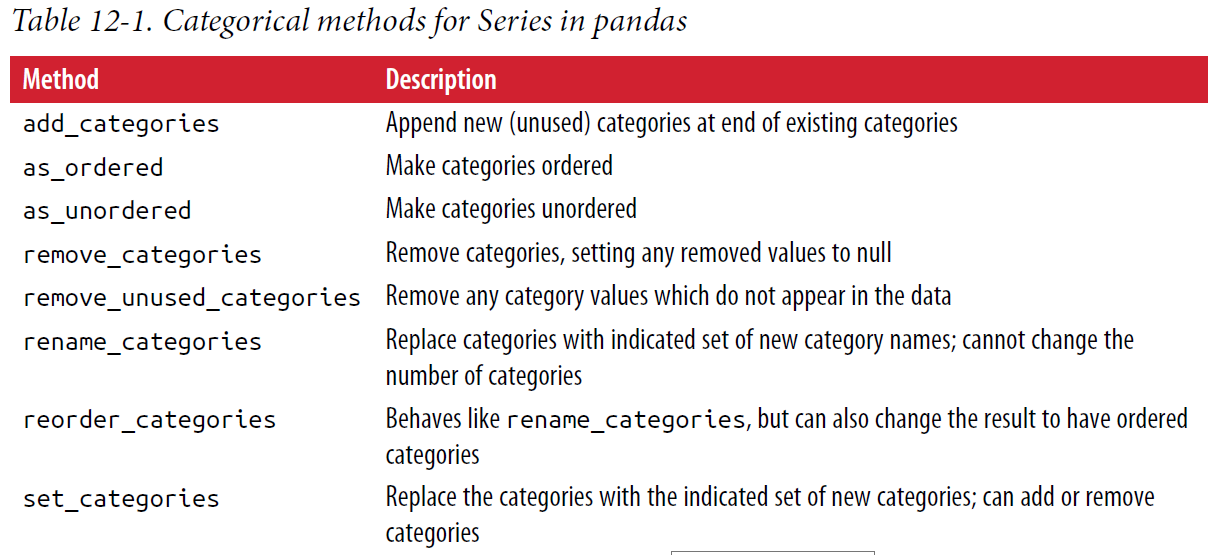

## Creating dummy variables for modeling
When you’re using statistics or machine learning tools, you’ll often transform categorical
data into dummy variables, also known as one-hot encoding. This involves creating
a DataFrame with a column for each distinct category; these columns contain 1s
for occurrences of a given category and 0 otherwise.

In [39]:
cat_s = pd.Series(['a', 'b', 'c', 'd'] * 2, dtype='category')
cat_s

0    a
1    b
2    c
3    d
4    a
5    b
6    c
7    d
dtype: category
Categories (4, object): ['a', 'b', 'c', 'd']

The `pandas.get_dummies` function converts
this one-dimensional categorical data into a DataFrame containing the dummy
variable:

In [40]:
pd.get_dummies(cat_s)

,a,b,c,d
0,1,0,0,0
1,0,1,0,0
2,0,0,1,0
3,0,0,0,1
4,1,0,0,0
5,0,1,0,0
6,0,0,1,0
7,0,0,0,1


# Advanced GroupBy Use
## Group Transforms and “Unwrapped” GroupBys

In Chapter 10 we looked at the apply method in grouped operations for performing
transformations. There is another built-in method called transform, which is similar
to apply but imposes more constraints on the kind of function you can use:

+ It can produce a scalar value to be broadcast to the shape of the group
+ It can produce an object of the same shape as the input group
+ It must not mutate its input

In [42]:
df = pd.DataFrame({'key': ['a', 'b', 'c'] * 4, 'value': np.arange(12.)})
df

,key,value
0,a,0.0
1,b,1.0
2,c,2.0
3,a,3.0
4,b,4.0
5,c,5.0
6,a,6.0
7,b,7.0
8,c,8.0
9,a,9.0


Here are the group means by key:

In [48]:
g = df.groupby('key').value
g.mean()

key
a    4.5
b    5.5
c    6.5
Name: value, dtype: float64

Suppose instead we wanted to produce a Series of the same shape as `df['value']` but
with values replaced by the average grouped by 'key'. We can pass the function
`lambda x: x.mean()` to transform:

In [44]:
g.transform(lambda x:x.mean())

0     4.5
1     5.5
2     6.5
3     4.5
4     5.5
5     6.5
6     4.5
7     5.5
8     6.5
9     4.5
10    5.5
11    6.5
Name: value, dtype: float64

For built-in aggregation functions, we can pass a string alias as with the GroupBy agg
method:

In [45]:
g.transform('mean')

0     4.5
1     5.5
2     6.5
3     4.5
4     5.5
5     6.5
6     4.5
7     5.5
8     6.5
9     4.5
10    5.5
11    6.5
Name: value, dtype: float64

Like `apply`, `transform` works with functions that return Series, but the result must be
the same size as the input. For example, we can multiply each group by 2 using a
lambda function:

In [46]:
g.transform(lambda x: x * 2)

0      0.0
1      2.0
2      4.0
3      6.0
4      8.0
5     10.0
6     12.0
7     14.0
8     16.0
9     18.0
10    20.0
11    22.0
Name: value, dtype: float64

As a more complicated example, we can compute the ranks in descending order for
each group:

In [49]:
g.transform(lambda x: x.rank(ascending=False))

0     4.0
1     4.0
2     4.0
3     3.0
4     3.0
5     3.0
6     2.0
7     2.0
8     2.0
9     1.0
10    1.0
11    1.0
Name: value, dtype: float64

Consider a group transformation function composed from simple aggregations. We can obtain equivalent results in this case either using `transform` or `apply`:

In [50]:
def normalize(x):
    return (x - x.mean()) / x.std()

g.transform(normalize)

0    -1.161895
1    -1.161895
2    -1.161895
3    -0.387298
4    -0.387298
5    -0.387298
6     0.387298
7     0.387298
8     0.387298
9     1.161895
10    1.161895
11    1.161895
Name: value, dtype: float64

In [51]:
g.apply(normalize)

0    -1.161895
1    -1.161895
2    -1.161895
3    -0.387298
4    -0.387298
5    -0.387298
6     0.387298
7     0.387298
8     0.387298
9     1.161895
10    1.161895
11    1.161895
Name: value, dtype: float64

Built-in aggregate functions like `'mean'` or `'sum'` are often much faster than a general
`apply` function. These also have a “fast past” when used with transform. This allows
us to perform a so-called unwrapped group operation:

In [52]:
g.transform('mean')

0     4.5
1     5.5
2     6.5
3     4.5
4     5.5
5     6.5
6     4.5
7     5.5
8     6.5
9     4.5
10    5.5
11    6.5
Name: value, dtype: float64

In [53]:
normalized = (df['value'] - g.transform('mean')) / g.transform('std')
normalized

0    -1.161895
1    -1.161895
2    -1.161895
3    -0.387298
4    -0.387298
5    -0.387298
6     0.387298
7     0.387298
8     0.387298
9     1.161895
10    1.161895
11    1.161895
Name: value, dtype: float64

While an unwrapped group operation may involve multiple group aggregations, the
overall benefit of vectorized operations often outweighs this.

## Grouped Time Resampling

For time series data, the resample method is semantically a group operation based on
a time intervalization. Here’s a small example table:

In [54]:
N = 15
times = pd.date_range('2017-05-20 00:00', freq='1min', periods=N)
df = pd.DataFrame({'time': times, 'value': np.arange(N)})
df

,time,value
0,2017-05-20 00:00:00,0
1,2017-05-20 00:01:00,1
2,2017-05-20 00:02:00,2
3,2017-05-20 00:03:00,3
4,2017-05-20 00:04:00,4
5,2017-05-20 00:05:00,5
6,2017-05-20 00:06:00,6
7,2017-05-20 00:07:00,7
8,2017-05-20 00:08:00,8
9,2017-05-20 00:09:00,9


Here, we can index by `'time'` and then resample:

In [55]:
df.set_index('time').resample('5min').count()

,value
time,
2017-05-20 00:00:00,5
2017-05-20 00:05:00,5
2017-05-20 00:10:00,5


Suppose that a DataFrame contains multiple time series, marked by an additional
group key column:

In [62]:
df2 = pd.DataFrame({'time': times.repeat(3), 
                    'key': np.tile(['a', 'b', 'c'], N), 
                    'value': np.arange(N * 3.)})
df2

,time,key,value
0,2017-05-20 00:00:00,a,0.0
1,2017-05-20 00:00:00,b,1.0
2,2017-05-20 00:00:00,c,2.0
3,2017-05-20 00:01:00,a,3.0
4,2017-05-20 00:01:00,b,4.0
5,2017-05-20 00:01:00,c,5.0
6,2017-05-20 00:02:00,a,6.0
7,2017-05-20 00:02:00,b,7.0
8,2017-05-20 00:02:00,c,8.0
9,2017-05-20 00:03:00,a,9.0


To do the same resampling for each value of `'key'`, we introduce the `pandas.Grouper` object. We can then set the time index, group by 'key' and time_key, and aggregate:

In [72]:
time_key = pd.Grouper(freq='5T')
resampled = (df2.set_index('time').groupby(['key', time_key]).sum())
resampled

value
key time                      
a   2017-05-20 00:00:00   30.0
    2017-05-20 00:05:00  105.0
    2017-05-20 00:10:00  180.0
b   2017-05-20 00:00:00   35.0
    2017-05-20 00:05:00  110.0
    2017-05-20 00:10:00  185.0
c   2017-05-20 00:00:00   40.0
    2017-05-20 00:05:00  115.0
    2017-05-20 00:10:00  190.0

In [73]:
resampled.reset_index()

,key,time,value
0,a,2017-05-20 00:00:00,30.0
1,a,2017-05-20 00:05:00,105.0
2,a,2017-05-20 00:10:00,180.0
3,b,2017-05-20 00:00:00,35.0
4,b,2017-05-20 00:05:00,110.0
5,b,2017-05-20 00:10:00,185.0
6,c,2017-05-20 00:00:00,40.0
7,c,2017-05-20 00:05:00,115.0
8,c,2017-05-20 00:10:00,190.0


# Techniques for Method Chaining

When applying a sequence of transformations to a dataset, you may find yourself creating
numerous temporary variables that are never used in your analysis. Consider
this example, for instance:

In [ ]:
df = load_data()
df2 = df[df['col2'] < 0]
df2['col1_demeaned'] = df2['col1'] - df2['col1'].mean()
result = df2.groupby('key').col1_demeaned.std()

While we’re not using any real data here, this example highlights some new methods.
First, the DataFrame.assign method is a functional alternative to column assignments
of the form df[k] = v. Rather than modifying the object in-place, it returns a
new DataFrame with the indicated modifications. So these statements are equivalent:

In [ ]:
#Usual non-functional way
df2 = df.copy()
df2['k'] = v

#Functional assign way
df2 = df.assign(k=v)

Assigning in-place may execute faster than using assign, but assign enables easier method chaining:

In [ ]:
result = (df2.assign(col1_demeaned=df2.col1 - df2.col2.mean())
          .groupby('key')
          .col1_demeaned.std())

I used the outer parentheses to make it more convenient to add line breaks.  
One thing to keep in mind when doing method chaining is that you may need to
refer to temporary objects. In the preceding example, we cannot refer to the result of
load_data until it has been assigned to the temporary variable df. To help with this,
assign and many other pandas functions accept function-like arguments, also known
as callables.
To show callables in action, consider a fragment of the example from before:

In [ ]:
df = load_data()
df2 = df[df['col2'] < 0]

#This can be rewritten as:
df2 = (load_data()
      [lambda x: x['col2'] < 0])

Here, the result of load_data is not assigned to a variable, so the function passed into
`[ ]` is then bound to the object at that stage of the method chain.  
We can continue, then, and write the entire sequence as a single chained expression:

In [ ]:
result = (load_data()
          [lambda x: x.col2 < 0]
          .assign(col1_demeaned=lambda x: x.col1 - x.col1.mean())
          .groupby('key')
          .col1_demeaned.std())

## The pipe Method

You can accomplish a lot with built-in pandas functions and the approaches to
method chaining with callables that we just looked at. However, sometimes you need
to use your own functions or functions from third-party libraries. This is where the
pipe method comes in.  
Consider a sequence of function calls:

In [ ]:
a = f(df, arg1=v1)
b = g(a, v2, arg3=v3)
c = h(b, arg4=v4)

When using functions that accept and return Series or DataFrame objects, you can
rewrite this using calls to pipe:

In [ ]:
result = (df.pipe(f, arg1=v1)
          .pipe(g, v2, arg3=v3)
          .pipe(h, arg4=v4))

The statement f(df) and df.pipe(f) are equivalent, but pipe makes chained invocation
easier.

A potentially useful pattern for pipe is to generalize sequences of operations into
reusable functions. As an example, let’s consider substracting group means from a
column:

In [ ]:
g = df.groupby(['key1', 'key2'])
df['col1'] = df['col1'] - g.transform('mean')

Suppose that you wanted to be able to demean more than one column and easily
change the group keys. Additionally, you might want to perform this transformation
in a method chain. Here is an example implementation:

In [ ]:
def group_demean(df, by, cols):
    result = df.copy()
    g = df.groupby(by)
    for c in cols:
        result[c] = df[c] - g[c].transform('mean')
    return result

Then it is possible to write:

In [ ]:
result = (df[df.col1 < 0]
          .pipe(group_demean, ['key1', 'key2'], ['col1']))

#### *Note - Most of the contents like images, examples, statements, etc in my notebooks / notes belongs to author "Wes McKinney" of book "Python for Data Analysis". I have collected / integrated them for study purpose and I don't own it.*